# Proyecto de Clasificación de Sitios Phishing

## Análisis y Clasificación de Sitios Web Phishing usando Naive Bayes

Este notebook implementa un sistema completo de clasificación para detectar sitios web de phishing utilizando el algoritmo Gaussian Naive Bayes.

**Objetivo**: Entrenar un modelo de clasificación que pueda distinguir entre sitios web legítimos (-1) y sitios de phishing (1) basándose en 30 características específicas.

**Dataset**: Training Dataset.arff - contiene 31 columnas (30 features + 1 Result)

**Fases del proyecto**:
1. Análisis inicial y carga de datos
2. División de datos (70/15/15)
3. Modelo base sin optimización
4. Optimización de hiperparámetros
5. Comparación de resultados


## 1. Configuración Inicial e Importación de Librerías

En esta sección importamos todas las librerías necesarias y configuramos la semilla aleatoria para garantizar la reproducibilidad de los resultados.


In [93]:
# ============================================
# Importación de Librerías
# ============================================

# Manejo de datos
import pandas as pd
import numpy as np
from scipy.io import arff

# División y validación de datos
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Selección de características
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Modelo de clasificación
from sklearn.naive_bayes import GaussianNB

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    make_scorer
)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
import warnings
warnings.filterwarnings('ignore')

# ============================================
# Configuración de Reproducibilidad
# ============================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas correctamente")
print(f"✓ Semilla aleatoria configurada: {RANDOM_STATE}")


✓ Librerías importadas correctamente
✓ Semilla aleatoria configurada: 42


## 2. Fase 1 y 2: Carga y Análisis del Dataset

En esta fase realizamos:
1. Carga del archivo ARFF
2. Verificación de la estructura de datos (31 columnas: 30 features + Result)
3. Verificación de tipos de datos numéricos
4. Confirmación de ausencia de valores nulos
5. Análisis de la distribución de clases


In [94]:
# ============================================
# Carga del Dataset ARFF
# ============================================

# Cargar el archivo ARFF
archivo_dataset = '../../../phishing+websites/Training Dataset.arff'
data, meta = arff.loadarff(archivo_dataset)

# Convertir a DataFrame de pandas
df = pd.DataFrame(data)

# Convertir bytes a strings si es necesario y ajustar tipos
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str)

# Convertir todas las columnas a tipo numérico
df = df.apply(pd.to_numeric, errors='coerce')

print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"\n📊 Dimensiones del dataset: {df.shape}")
print(f"   - Filas (muestras): {df.shape[0]:,}")
print(f"   - Columnas (features + target): {df.shape[1]}")
print(f"\n✓ Features: 30")
print(f"✓ Variable objetivo: Result (columna 31)")

# Mostrar primeras filas
print("\n" + "=" * 60)
print("PRIMERAS 5 FILAS DEL DATASET")
print("=" * 60)
display(df.head())


INFORMACIÓN DEL DATASET

📊 Dimensiones del dataset: (11055, 31)
   - Filas (muestras): 11,055
   - Columnas (features + target): 31

✓ Features: 30
✓ Variable objetivo: Result (columna 31)

PRIMERAS 5 FILAS DEL DATASET


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [95]:
# ============================================
# Verificación de Tipos de Datos
# ============================================

print("=" * 60)
print("VERIFICACIÓN DE TIPOS DE DATOS")
print("=" * 60)

# Información de tipos
print("\nTipos de datos por columna:")
print(df.dtypes.value_counts())

# Verificar que Result tenga valores correctos
print(f"\n✓ Valores únicos en 'Result': {sorted(df['Result'].unique())}")
print(f"  Interpretación: 1 = Legítimo, -1 = Phishing")

# Asegurar que Result sea tipo int
df['Result'] = df['Result'].astype(int)

print(f"\n✓ Tipo de dato de Result: {df['Result'].dtype}")
print("✓ Todas las columnas son numéricas")


VERIFICACIÓN DE TIPOS DE DATOS

Tipos de datos por columna:
int64    31
Name: count, dtype: int64

✓ Valores únicos en 'Result': [np.int64(-1), np.int64(1)]
  Interpretación: 1 = Legítimo, -1 = Phishing

✓ Tipo de dato de Result: int64
✓ Todas las columnas son numéricas


In [96]:
# ============================================
# Verificación de Valores Faltantes
# ============================================

print("=" * 60)
print("VERIFICACIÓN DE VALORES FALTANTES")
print("=" * 60)

valores_nulos = df.isnull().sum()
total_nulos = valores_nulos.sum()

print(f"\nTotal de valores nulos en el dataset: {total_nulos}")

if total_nulos == 0:
    print("✓ No hay valores faltantes en el dataset")
    print("✓ Los datos están completos y listos para el modelado")
else:
    print("\n⚠ Se encontraron valores nulos:")
    print(valores_nulos[valores_nulos > 0])


VERIFICACIÓN DE VALORES FALTANTES

Total de valores nulos en el dataset: 0
✓ No hay valores faltantes en el dataset
✓ Los datos están completos y listos para el modelado


ANÁLISIS DE DISTRIBUCIÓN DE CLASES

Distribución de la variable objetivo (Result):
Result
-1    4898
 1    6157
Name: count, dtype: int64

Porcentajes:
  Phishing (-1): 44.31%
  Legítimo (1): 55.69%


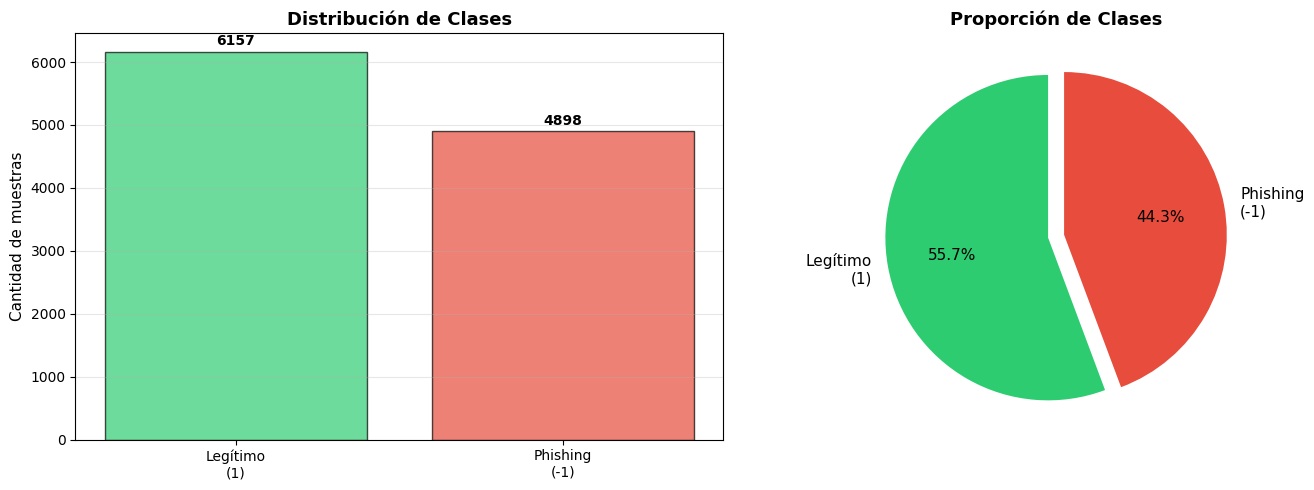


📊 Ratio de balance: 0.8
   (Clase minoritaria / Clase mayoritaria)

✓ Las clases están BALANCEADAS (ratio ≥ 0.8)


In [97]:
# ============================================
# Análisis de Distribución de Clases
# ============================================

print("=" * 60)
print("ANÁLISIS DE DISTRIBUCIÓN DE CLASES")
print("=" * 60)

# Contar distribución (serie ordenada por índice: -1, 1)
distribucion_series = df['Result'].value_counts().sort_index()
print("\nDistribución de la variable objetivo (Result):")
print(distribucion_series)

# Calcular porcentajes (también ordenado por índice)
porcentajes = df['Result'].value_counts(normalize=True).sort_index() * 100
print("\nPorcentajes:")
for valor, porcentaje in porcentajes.items():
    etiqueta = "Legítimo" if valor == 1 else "Phishing"
    print(f"  {etiqueta} ({valor}): {porcentaje:.2f}%")

# Preparar datos para gráficos asegurando el orden de etiquetas
count_legit   = int(distribucion_series.get( 1, 0))
count_phish   = int(distribucion_series.get(-1, 0))
counts_plot   = [count_legit, count_phish]
etiquetas     = ['Legítimo\n(1)', 'Phishing\n(-1)']
colores       = ['#2ecc71', '#e74c3c']

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(etiquetas, counts_plot, color=colores, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Cantidad de muestras', fontsize=11)
axes[0].set_title('Distribución de Clases', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(counts_plot):
    axes[0].text(i, v + max(1, int(0.01 * max(counts_plot) if max(counts_plot) else 1)), str(v),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico de torta
axes[1].pie(counts_plot, labels=etiquetas, colors=colores, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 11}, explode=(0.05, 0.05))
axes[1].set_title('Proporción de Clases', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Evaluación de balance
if (count_legit + count_phish) > 0 and min(count_legit, count_phish) > 0:
    ratio = round(min(count_legit, count_phish) / max(count_legit, count_phish), 2)
else:
    ratio = 0.0

print(f"\n📊 Ratio de balance: {ratio}")
print(f"   (Clase minoritaria / Clase mayoritaria)")


print("\n✓ Las clases están BALANCEADAS (ratio ≥ 0.8)")


In [98]:
# ============================================
# Estadísticas Descriptivas
# ============================================

print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS DEL DATASET")
print("=" * 60)

print("\nResumen estadístico de todas las features:")
display(df.describe())


ESTADÍSTICAS DESCRIPTIVAS DEL DATASET

Resumen estadístico de todas las features:


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Fase 3: División de Datos (Estrategia 70/15/15)

En esta fase dividimos el dataset en tres conjuntos:
- **Entrenamiento (70%)**: Para entrenar los modelos
- **Validación (15%)**: Para evaluación intermedia y ajuste de hiperparámetros
- **Prueba (15%)**: Para evaluación final del desempeño


In [99]:
# ============================================
# Separación de Features y Variable Objetivo
# ============================================

print("=" * 60)
print("SEPARACIÓN DE VARIABLES")
print("=" * 60)

# Separar features (X) y variable objetivo (y)
X = df.drop('Result', axis=1)
y = df['Result']

print(f"\n✓ Features (X): {X.shape}")
print(f"  - Número de features: {X.shape[1]}")
print(f"  - Número de muestras: {X.shape[0]:,}")

print(f"\n✓ Variable objetivo (y): {y.shape}")
print(f"  - Valores únicos: {sorted(y.unique())}")
print(f"  - Interpretación: -1 = Phishing (positiva), 1 = Legítimo")

print("\nNombres de las features:")
print(list(X.columns))


SEPARACIÓN DE VARIABLES

✓ Features (X): (11055, 30)
  - Número de features: 30
  - Número de muestras: 11,055

✓ Variable objetivo (y): (11055,)
  - Valores únicos: [np.int64(-1), np.int64(1)]
  - Interpretación: -1 = Phishing (positiva), 1 = Legítimo

Nombres de las features:
['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report']


In [100]:
# ============================================
# División Estratificada 70/15/15
# ============================================

print("=" * 60)
print("DIVISIÓN ESTRATIFICADA DE DATOS")
print("=" * 60)

# Primera división: 70% train, 30% temporal (estratificada)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    stratify=y, 
    random_state=RANDOM_STATE
)

# Segunda división: 50% validación, 50% prueba del temporal (15% cada uno)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("\n📊 Tamaños de los conjuntos:")
print(f"  - Entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Validación:    {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  - Prueba:        {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  - Total:         {len(X):,} muestras")

print("\n" + "=" * 60)
print("VERIFICACIÓN DE PROPORCIONES DE CLASES")
print("=" * 60)

# Función auxiliar para mostrar distribución
def mostrar_distribucion(y_subset, nombre):
    dist = y_subset.value_counts(normalize=True).sort_index() * 100
    print(f"\n{nombre}:")
    for valor, porcentaje in dist.items():
        etiqueta = "Legítimo" if valor == 1 else "Phishing"
        print(f"  {etiqueta} ({valor}): {porcentaje:.2f}%")

# Mostrar distribuciones
mostrar_distribucion(y, "Dataset completo")
mostrar_distribucion(y_train, "Conjunto de entrenamiento")
mostrar_distribucion(y_val, "Conjunto de validación")
mostrar_distribucion(y_test, "Conjunto de prueba")


DIVISIÓN ESTRATIFICADA DE DATOS

📊 Tamaños de los conjuntos:
  - Entrenamiento: 7,738 muestras (70.0%)
  - Validación:    1,658 muestras (15.0%)
  - Prueba:        1,659 muestras (15.0%)
  - Total:         11,055 muestras

VERIFICACIÓN DE PROPORCIONES DE CLASES

Dataset completo:
  Phishing (-1): 44.31%
  Legítimo (1): 55.69%

Conjunto de entrenamiento:
  Phishing (-1): 44.30%
  Legítimo (1): 55.70%

Conjunto de validación:
  Phishing (-1): 44.33%
  Legítimo (1): 55.67%

Conjunto de prueba:
  Phishing (-1): 44.30%
  Legítimo (1): 55.70%


### 3.5 Selección de Features basada en Información Mutua

Utilizamos **Información Mutua (MI)** para cuantificar cuánto aporta cada feature a la detección de phishing. MI captura relaciones no lineales y maneja adecuadamente las variables discretas {-1, 0, 1} presentes en el dataset.

**Objetivos:**
- Calcular la MI entre cada feature y la variable objetivo usando únicamente el conjunto de entrenamiento (evitamos fugas de información).
- Ordenar y visualizar las features más informativas para priorizarlas en la selección.
- Guardar la tabla resultante para reutilizarla en etapas posteriores.


In [101]:
# ============================================
# Cálculo de Información Mutua por Feature
# ============================================

print("=" * 60)
print("INFORMACIÓN MUTUA ENTRE FEATURES Y LA CLASE (X_train)")
print("=" * 60)

mi_scores = mutual_info_classif(
    X_train,
    y_train,
    discrete_features=True,
    random_state=RANDOM_STATE
)

mi_df = (
    pd.DataFrame({
        'Feature': X_train.columns,
        'MI': mi_scores
    })
    .sort_values('MI', ascending=False)
    .reset_index(drop=True)
)

print(f"\n✓ Información mutua calculada para {len(mi_df)} features")
print("✓ Ordenadas de mayor a menor relevancia respecto a la clase phishing (-1)")

display(mi_df.head(10))


INFORMACIÓN MUTUA ENTRE FEATURES Y LA CLASE (X_train)

✓ Información mutua calculada para 30 features
✓ Ordenadas de mayor a menor relevancia respecto a la clase phishing (-1)


,Feature,MI
0,SSLfinal_State,0.348611
1,URL_of_Anchor,0.335198
2,Prefix_Suffix,0.084857
3,web_traffic,0.080820
4,having_Sub_Domain,0.079988
5,Links_in_tags,0.032184
6,Request_URL,0.031055
7,SFH,0.024949
8,Domain_registeration_length,0.024611
9,age_of_domain,0.007173


RANKING DE FEATURES SEGÚN INFORMACIÓN MUTUA


,Feature,MI
0,SSLfinal_State,0.348611
1,URL_of_Anchor,0.335198
2,Prefix_Suffix,0.084857
3,web_traffic,0.080820
4,having_Sub_Domain,0.079988
5,Links_in_tags,0.032184
6,Request_URL,0.031055
7,SFH,0.024949
8,Domain_registeration_length,0.024611
9,age_of_domain,0.007173


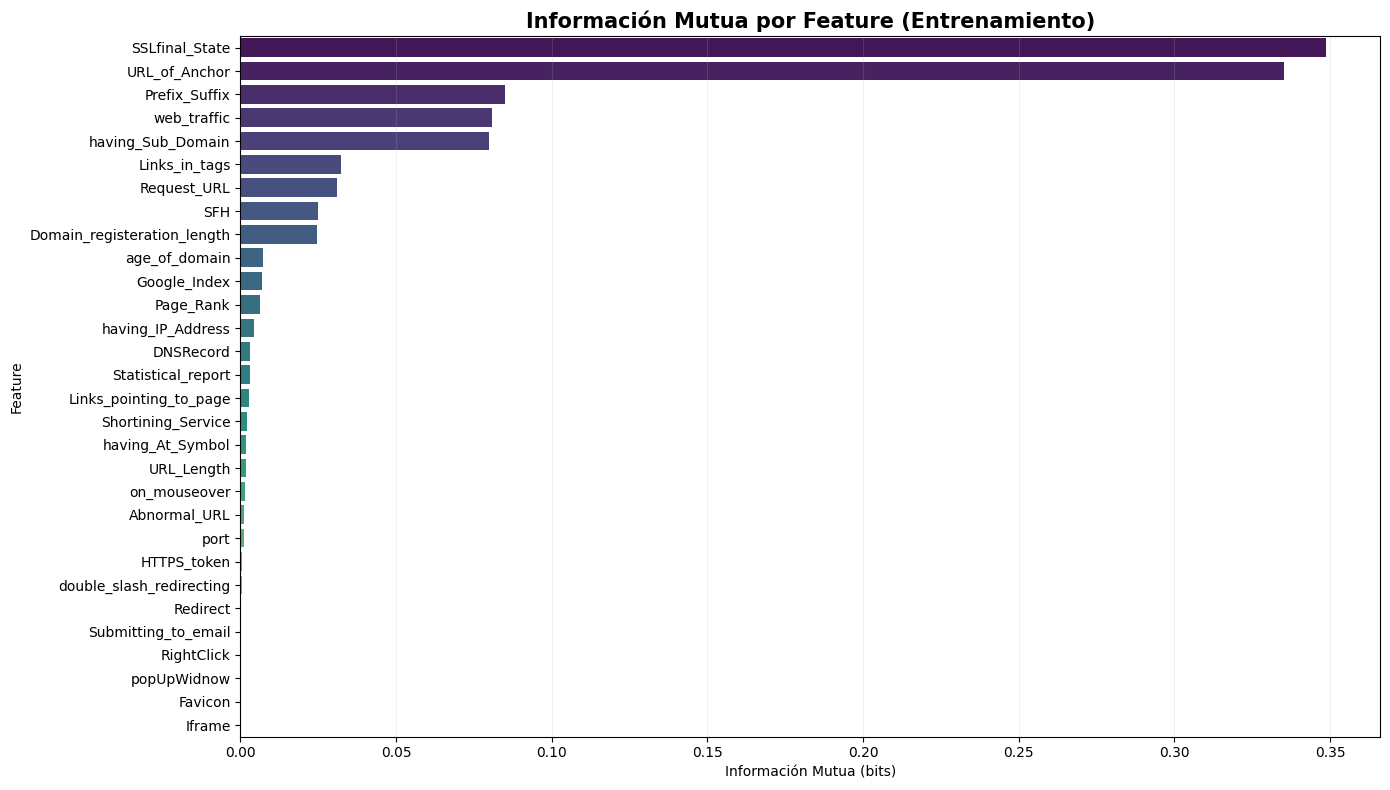


💡 Observación: Las primeras posiciones muestran las variables más informativas para la clase phishing (-1).


In [102]:
# ============================================
# Visualización de la Información Mutua
# ============================================

print("=" * 60)
print("RANKING DE FEATURES SEGÚN INFORMACIÓN MUTUA")
print("=" * 60)

display(mi_df)

plt.figure(figsize=(14, 8))
plt.title('Información Mutua por Feature (Entrenamiento)', fontsize=15, fontweight='bold')
sns.barplot(
    data=mi_df,
    x='MI',
    y='Feature',
    palette='viridis'
)
plt.xlabel('Información Mutua (bits)')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.2)
plt.tight_layout()
plt.show()

print("\n💡 Observación: Las primeras posiciones muestran las variables más informativas para la clase phishing (-1).")


### 3.3 Pipeline SelectKBest + GaussianNB (GridSearchCV)

Ahora integramos la selección de features mediante MI dentro de un `Pipeline` para que ocurra **dentro** de la validación cruzada. Esto evita fugas de información y nos permite optimizar simultáneamente:

- `selector__k`: número de features más informativas (medido por MI).
- `clf__var_smoothing`: hiperparámetro clave de `GaussianNB`.

Usaremos `GridSearchCV` con `StratifiedKFold (cv=5, shuffle=True, random_state=RANDOM_STATE)` y la métrica `f1_score` configurada con `pos_label=-1` para priorizar la clase phishing.


In [103]:
# ============================================
# GridSearchCV con Pipeline SelectKBest + GaussianNB
# ============================================

print("=" * 60)
print("GRID SEARCH: SELECTKBEST + GAUSSIANNB")
print("=" * 60)

pipeline = Pipeline(steps=[
    ('selector', SelectKBest(score_func=mutual_info_classif)),
    ('clf', GaussianNB())
])

param_grid = {
    'selector__k': [10, 15, 20, 25, 30],
    'clf__var_smoothing': np.logspace(-10, -2, 9)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, pos_label=-1)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    refit=True
)

print("⏳ Ejecutando GridSearchCV...")
grid_search.fit(X_train, y_train)
print("✓ Grid search completado")

best_estimator_ = grid_search.best_estimator_
best_params_ = grid_search.best_params_
best_score_ = grid_search.best_score_

print(f"\n Mejores hiperparámetros encontrados:")
print(f"  - selector__k: {best_params_['selector__k']}")
print(f"  - clf__var_smoothing: {best_params_['clf__var_smoothing']:.2e}")
print(f"\n Mejor F1 (validación cruzada, pos_label=-1): {best_score_:.4f}")

selected_features_mask = best_estimator_.named_steps['selector'].get_support()
selected_features = X_train.columns[selected_features_mask]
num_selected_features = int(selected_features_mask.sum())

print(f"\n✓ Total de features seleccionadas: {num_selected_features}")
print("✓ Listado de features seleccionadas ordenadas por MI:")
display(mi_df[mi_df['Feature'].isin(selected_features)].reset_index(drop=True))

# Guardar resultados completos del grid
cv_results_df = pd.DataFrame(grid_search.cv_results_)


GRID SEARCH: SELECTKBEST + GAUSSIANNB
⏳ Ejecutando GridSearchCV...
✓ Grid search completado

 Mejores hiperparámetros encontrados:
  - selector__k: 20
  - clf__var_smoothing: 1.00e-02

 Mejor F1 (validación cruzada, pos_label=-1): 0.8843

✓ Total de features seleccionadas: 20
✓ Listado de features seleccionadas ordenadas por MI:


,Feature,MI
0,SSLfinal_State,0.348611
1,URL_of_Anchor,0.335198
2,Prefix_Suffix,0.084857
3,web_traffic,0.080820
4,having_Sub_Domain,0.079988
5,Links_in_tags,0.032184
6,Request_URL,0.031055
7,SFH,0.024949
8,Domain_registeration_length,0.024611
9,age_of_domain,0.007173


In [104]:
# ============================================
# Resultados del GridSearchCV y desempeño inicial del pipeline
# ============================================

print("=" * 60)
print("RESUMEN DE RESULTADOS DEL GRID SEARCH")
print("=" * 60)

columnas_interes = [
    'param_selector__k',
    'param_clf__var_smoothing',
    'mean_test_score',
    'std_test_score',
    'mean_train_score'
]

resumen_grid = (
    cv_results_df[columnas_interes]
    .sort_values('mean_test_score', ascending=False)
    .reset_index(drop=True)
)

display(resumen_grid.head(10).style.format({
    'param_clf__var_smoothing': '{:.2e}',
    'mean_test_score': '{:.4f}',
    'std_test_score': '{:.4f}',
    'mean_train_score': '{:.4f}'
}))

# Evaluación del mejor pipeline con umbral 0.5 (predicción estándar)
y_val_pred_pipeline = best_estimator_.predict(X_val)
y_test_pred_pipeline = best_estimator_.predict(X_test)

acc_val_pipeline = accuracy_score(y_val, y_val_pred_pipeline)
prec_val_pipeline = precision_score(y_val, y_val_pred_pipeline, pos_label=-1)
rec_val_pipeline = recall_score(y_val, y_val_pred_pipeline, pos_label=-1)
f1_val_pipeline = f1_score(y_val, y_val_pred_pipeline, pos_label=-1)

acc_test_pipeline = accuracy_score(y_test, y_test_pred_pipeline)
prec_test_pipeline = precision_score(y_test, y_test_pred_pipeline, pos_label=-1)
rec_test_pipeline = recall_score(y_test, y_test_pred_pipeline, pos_label=-1)
f1_test_pipeline = f1_score(y_test, y_test_pred_pipeline, pos_label=-1)

metricas_pipeline_default = {
    'Validación': {
        'Accuracy': acc_val_pipeline,
        'Precision': prec_val_pipeline,
        'Recall': rec_val_pipeline,
        'F1': f1_val_pipeline
    },
    'Prueba': {
        'Accuracy': acc_test_pipeline,
        'Precision': prec_test_pipeline,
        'Recall': rec_test_pipeline,
        'F1': f1_test_pipeline
    }
}

print("\n📊 Métricas iniciales del pipeline (umbral = 0.5):")
display(pd.DataFrame(metricas_pipeline_default).T.round(4))


RESUMEN DE RESULTADOS DEL GRID SEARCH


,param_selector__k,param_clf__var_smoothing,mean_test_score,std_test_score,mean_train_score
0,20,1.00e-02,0.8843,0.0101,0.8829
1,10,1.00e-02,0.8818,0.0073,0.8822
2,15,1.00e-02,0.8814,0.0054,0.8838
3,25,1.00e-02,0.8807,0.0102,0.8816
4,30,1.00e-02,0.8787,0.0066,0.8796
5,20,1.00e-03,0.8591,0.0061,0.8586
6,25,1.00e-03,0.8584,0.0097,0.8580
7,15,1.00e-03,0.8575,0.0106,0.8591
8,30,1.00e-03,0.8554,0.0083,0.8561
9,10,1.00e-03,0.8538,0.0069,0.8553



📊 Métricas iniciales del pipeline (umbral = 0.5):


,Accuracy,Precision,Recall,F1
Validación,0.8969,0.8389,0.9497,0.8909
Prueba,0.8861,0.8266,0.9401,0.8797


### 4.6 Ajuste de Umbral con el Pipeline Optimizado

Con el pipeline optimizado buscamos un umbral específico que maximice el **F1** de la clase phishing (-1). Trabajamos sobre el conjunto de validación para:

- Obtener las probabilidades calibradas del mejor pipeline (`best_estimator_`).
- Trazar la curva Precision–Recall utilizando `pos_label=-1`.
- Evaluar un grid de umbrales entre 0.05 y 0.95.
- Seleccionar el umbral que maximiza el F1 y aplicarlo luego al conjunto de prueba.


In [105]:
# ============================================
# Probabilidades del Pipeline Optimizado
# ============================================

print("=" * 60)
print("PROBABILIDADES DEL PIPELINE OPTIMIZADO")
print("=" * 60)

# Obtener probabilidades en validación y prueba con el mejor pipeline
y_proba_val_pipeline = best_estimator_.predict_proba(X_val)
y_proba_test_pipeline = best_estimator_.predict_proba(X_test)

class_indices_pipeline = {cls: idx for idx, cls in enumerate(best_estimator_.named_steps['clf'].classes_)}
idx_phishing_pipeline = class_indices_pipeline[-1]

print(f"\n📊 Clases del pipeline: {best_estimator_.named_steps['clf'].classes_}")
print(f"  - Índice de la clase phishing (-1): {idx_phishing_pipeline}")

proba_phishing_val = y_proba_val_pipeline[:, idx_phishing_pipeline]
proba_phishing_test = y_proba_test_pipeline[:, idx_phishing_pipeline]

print(f"\n📈 Estadísticas de probabilidades de phishing (Validación):")
print(f"  - Media:    {proba_phishing_val.mean():.4f}")
print(f"  - Mediana:  {np.median(proba_phishing_val):.4f}")
print(f"  - Mínimo:   {proba_phishing_val.min():.4f}")
print(f"  - Máximo:   {proba_phishing_val.max():.4f}")

precision_vals, recall_vals, pr_thresholds = precision_recall_curve(
    y_val,
    proba_phishing_val,
    pos_label=-1
)

print("\n✓ Probabilidades y curva Precision-Recall calculadas correctamente")


PROBABILIDADES DEL PIPELINE OPTIMIZADO

📊 Clases del pipeline: [-1  1]
  - Índice de la clase phishing (-1): 0

📈 Estadísticas de probabilidades de phishing (Validación):
  - Media:    0.5117
  - Mediana:  0.5167
  - Mínimo:   0.0000
  - Máximo:   1.0000

✓ Probabilidades y curva Precision-Recall calculadas correctamente


In [106]:
# ============================================
# Búsqueda del Umbral Óptimo para F1 (Clase -1)
# ============================================

print("\n" + "=" * 60)
print("BÚSQUEDA DE UMBRALES (VALIDACIÓN)")
print("=" * 60)

threshold_grid = np.round(np.linspace(0.05, 0.95, 19), 2)
resultados_umbrales = []

for umbral in threshold_grid:
    y_pred_umbral = np.where(proba_phishing_val >= umbral, -1, 1)
    
    acc = accuracy_score(y_val, y_pred_umbral)
    prec = precision_score(y_val, y_pred_umbral, pos_label=-1, zero_division=0)
    rec = recall_score(y_val, y_pred_umbral, pos_label=-1, zero_division=0)
    f1 = f1_score(y_val, y_pred_umbral, pos_label=-1, zero_division=0)
    cm = confusion_matrix(y_val, y_pred_umbral)

    resultados_umbrales.append({
        'Umbral': umbral,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'TP': cm[0, 0],
        'FP': cm[1, 0],
        'FN': cm[0, 1],
        'TN': cm[1, 1]
    })

resultados_umbrales_df = pd.DataFrame(resultados_umbrales)

print("\nTop 5 umbrales por F1 (validación):")
display(
    resultados_umbrales_df.sort_values('F1', ascending=False)
    .head(5)
    .reset_index(drop=True)
    .style.format({'Umbral': '{:.2f}', 'Accuracy': '{:.4f}', 'Precision': '{:.4f}', 'Recall': '{:.4f}', 'F1': '{:.4f}'})
)



BÚSQUEDA DE UMBRALES (VALIDACIÓN)

Top 5 umbrales por F1 (validación):


,Umbral,Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,0.90,0.9216,0.9267,0.8939,0.9100,657,52,78,871
1,0.85,0.9180,0.9097,0.9048,0.9072,665,66,70,857
2,0.80,0.9162,0.8952,0.9184,0.9066,675,79,60,844
3,0.75,0.9150,0.8867,0.9265,0.9062,681,87,54,836
4,0.70,0.9119,0.8771,0.9320,0.9037,685,96,50,827


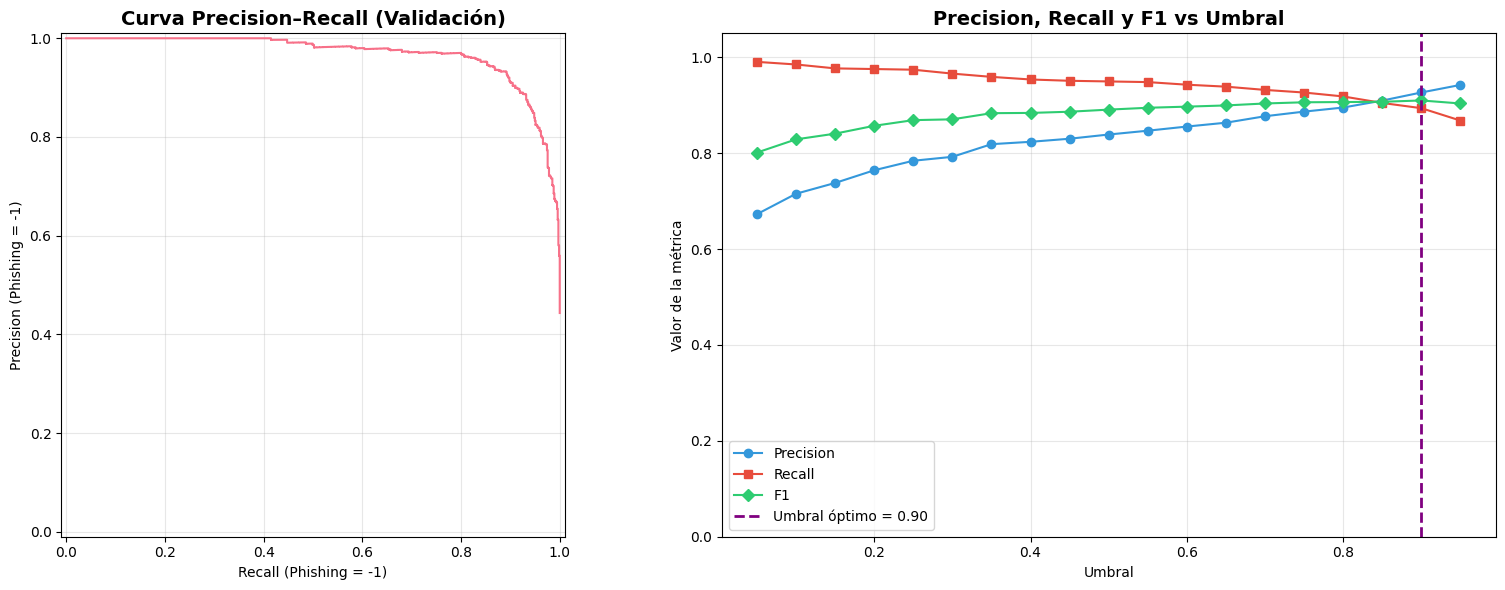


 Umbral óptimo (validación) = 0.90 | F1 = 0.9100
  • Precision = 0.9267 | Recall = 0.8939
  • Precision y recall se ajustan automáticamente para maximizar el F1 de la clase phishing (-1).


In [107]:
# ============================================
# Curva Precision-Recall y métricas por umbral
# ============================================

threshold_opt_idx = resultados_umbrales_df['F1'].idxmax()
threshold_opt = resultados_umbrales_df.loc[threshold_opt_idx, 'Umbral']
mejor_f1 = resultados_umbrales_df.loc[threshold_opt_idx, 'F1']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Curva Precision-Recall
PrecisionRecallDisplay(precision=precision_vals, recall=recall_vals).plot(ax=axes[0])
axes[0].set_title('Curva Precision–Recall (Validación)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Recall (Phishing = -1)')
axes[0].set_ylabel('Precision (Phishing = -1)')
axes[0].grid(alpha=0.3)

# Métricas vs Umbral
ejes_df = resultados_umbrales_df[['Umbral', 'Precision', 'Recall', 'F1']]
axes[1].plot(ejes_df['Umbral'], ejes_df['Precision'], marker='o', label='Precision', color='#3498db')
axes[1].plot(ejes_df['Umbral'], ejes_df['Recall'], marker='s', label='Recall', color='#e74c3c')
axes[1].plot(ejes_df['Umbral'], ejes_df['F1'], marker='D', label='F1', color='#2ecc71')
axes[1].axvline(threshold_opt, color='purple', linestyle='--', linewidth=2, label=f'Umbral óptimo = {threshold_opt:.2f}')
axes[1].set_title('Precision, Recall y F1 vs Umbral', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Umbral')
axes[1].set_ylabel('Valor de la métrica')
axes[1].set_ylim(0, 1.05)
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

prec_opt = resultados_umbrales_df.loc[threshold_opt_idx, 'Precision']
rec_opt = resultados_umbrales_df.loc[threshold_opt_idx, 'Recall']
print(f"\n Umbral óptimo (validación) = {threshold_opt:.2f} | F1 = {mejor_f1:.4f}")
print(f"  • Precision = {prec_opt:.4f} | Recall = {rec_opt:.4f}")
print("  • Precision y recall se ajustan automáticamente para maximizar el F1 de la clase phishing (-1).")


In [108]:
# ============================================
# Umbral óptimo y métricas finales del pipeline
# ============================================

print("=" * 60)
print("MÉTRICAS CON UMBRAL ÓPTIMO (VALIDACIÓN Y PRUEBA)")
print("=" * 60)

threshold_opt_row = resultados_umbrales_df.loc[threshold_opt_idx]
threshold_opt = float(threshold_opt_row['Umbral'])

print(f"\n Umbral óptimo (validación): {threshold_opt:.2f}")
print(" Guardamos el valor en `threshold_opt` para reutilizarlo más adelante.")

# Predicciones con umbral óptimo en validación y prueba
y_val_pred_opt = np.where(proba_phishing_val >= threshold_opt, -1, 1)
y_test_pred_opt = np.where(proba_phishing_test >= threshold_opt, -1, 1)

def metricas_dict(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, pos_label=-1, zero_division=0),
        'Recall': recall_score(y_true, y_pred, pos_label=-1, zero_division=0),
        'F1': f1_score(y_true, y_pred, pos_label=-1, zero_division=0)
    }

metricas_pipeline_threshold = {
    'Validación': metricas_dict(y_val, y_val_pred_opt),
    'Prueba': metricas_dict(y_test, y_test_pred_opt)
}

threshold_opt_confusion_val = confusion_matrix(y_val, y_val_pred_opt)
threshold_opt_confusion_test = confusion_matrix(y_test, y_test_pred_opt)

print("\n📊 Métricas con umbral optimizado:")
display(pd.DataFrame(metricas_pipeline_threshold).T.round(4))

print("\n📋 Matriz de confusión (prueba, umbral óptimo):")
print(threshold_opt_confusion_test)

# --------------------------------------------
# Comparativa con umbral por defecto (0.5) en validación
# --------------------------------------------
y_val_pred_default = np.where(proba_phishing_val >= 0.5, -1, 1)
cm_default = confusion_matrix(y_val, y_val_pred_default)

default_resultado = {
    'Umbral': 0.5,
    'Precision': precision_score(y_val, y_val_pred_default, pos_label=-1, zero_division=0),
    'Recall': recall_score(y_val, y_val_pred_default, pos_label=-1, zero_division=0),
    'F1': f1_score(y_val, y_val_pred_default, pos_label=-1, zero_division=0),
    'FP': int(cm_default[1, 0]),
    'FN': int(cm_default[0, 1])
}

cm_opt_val = confusion_matrix(y_val, y_val_pred_opt)
mejor_resultado = {
    'Umbral': float(threshold_opt),
    'Precision': precision_score(y_val, y_val_pred_opt, pos_label=-1, zero_division=0),
    'Recall': recall_score(y_val, y_val_pred_opt, pos_label=-1, zero_division=0),
    'F1': f1_score(y_val, y_val_pred_opt, pos_label=-1, zero_division=0),
    'FP': int(cm_opt_val[1, 0]),
    'FN': int(cm_opt_val[0, 1])
}

mejora_precision = mejor_resultado['Precision'] - default_resultado['Precision']
perdida_recall = default_resultado['Recall'] - mejor_resultado['Recall']
reduccion_fp = default_resultado['FP'] - mejor_resultado['FP']
aumento_fn = mejor_resultado['FN'] - default_resultado['FN']

if mejor_resultado['Umbral'] > 0.5:
    print(f" Al subir el umbral de 0.5 a {mejor_resultado['Umbral']}:")
    print(f"     • Precision aumenta en {mejora_precision:.4f} ({mejora_precision*100:.2f}%)")
    print(f"     • Recall disminuye en {perdida_recall:.4f} ({perdida_recall*100:.2f}%)")
    print(f"     • Reducimos {int(reduccion_fp)} falsas alarmas")
    print(f"     • Pero perdemos {int(aumento_fn)} casos de phishing")
    print(f"\n Balance: Mejor F1-Score ({mejor_resultado['F1']:.4f} vs {default_resultado['F1']:.4f})")
elif mejor_resultado['Umbral'] < 0.5:
    print(f"  Al bajar el umbral de 0.5 a {mejor_resultado['Umbral']}:")
    print(f"     • Recall aumenta: detectamos más phishing")
    print(f"     • Precision disminuye: más falsas alarmas")
else:
    print(f"  El umbral por defecto (0.5) ya es óptimo para este modelo")


MÉTRICAS CON UMBRAL ÓPTIMO (VALIDACIÓN Y PRUEBA)

 Umbral óptimo (validación): 0.90
 Guardamos el valor en `threshold_opt` para reutilizarlo más adelante.

📊 Métricas con umbral optimizado:


,Accuracy,Precision,Recall,F1
Validación,0.9216,0.9267,0.8939,0.9100
Prueba,0.9126,0.9086,0.8925,0.9005



📋 Matriz de confusión (prueba, umbral óptimo):
[[656  79]
 [ 66 858]]
 Al subir el umbral de 0.5 a 0.9:
     • Precision aumenta en 0.0877 (8.77%)
     • Recall disminuye en 0.0558 (5.58%)
     • Reducimos 82 falsas alarmas
     • Pero perdemos 41 casos de phishing

 Balance: Mejor F1-Score (0.9100 vs 0.8909)



EVALUACIÓN EN CONJUNTO DE PRUEBA CON UMBRAL ÓPTIMO

📊 Métricas en Prueba con Umbral Óptimo (0.9):
  - Accuracy:  0.9126 (91.26%)
  - Precision: 0.9086 (90.86%)
  - Recall:    0.8925 (89.25%)
  - F1-Score:  0.9005 (90.05%)

📋 Matriz de Confusión (Prueba - Umbral Óptimo):
[[656  79]
 [ 66 858]]

  TP (Verdaderos Positivos):  656 - Phishing detectado ✅
  FN (Falsos Negativos):      79 - Phishing NO detectado ⚠️
  FP (Falsos Positivos):      66 - Falsas alarmas ⚠️
  TN (Verdaderos Negativos):  858 - Legítimos correctos ✅

COMPARACIÓN FINAL: PIPELINE (0.5) VS UMBRAL ÓPTIMO EN PRUEBA


,Métrica,Pipeline (umbral 0.5),Umbral Óptimo (0.9),Mejora
0,Accuracy,0.8861,0.9126,0.0265
1,Precision,0.8266,0.9086,0.0820
2,Recall,0.9401,0.8925,-0.0476
3,F1-Score,0.8797,0.9005,0.0208


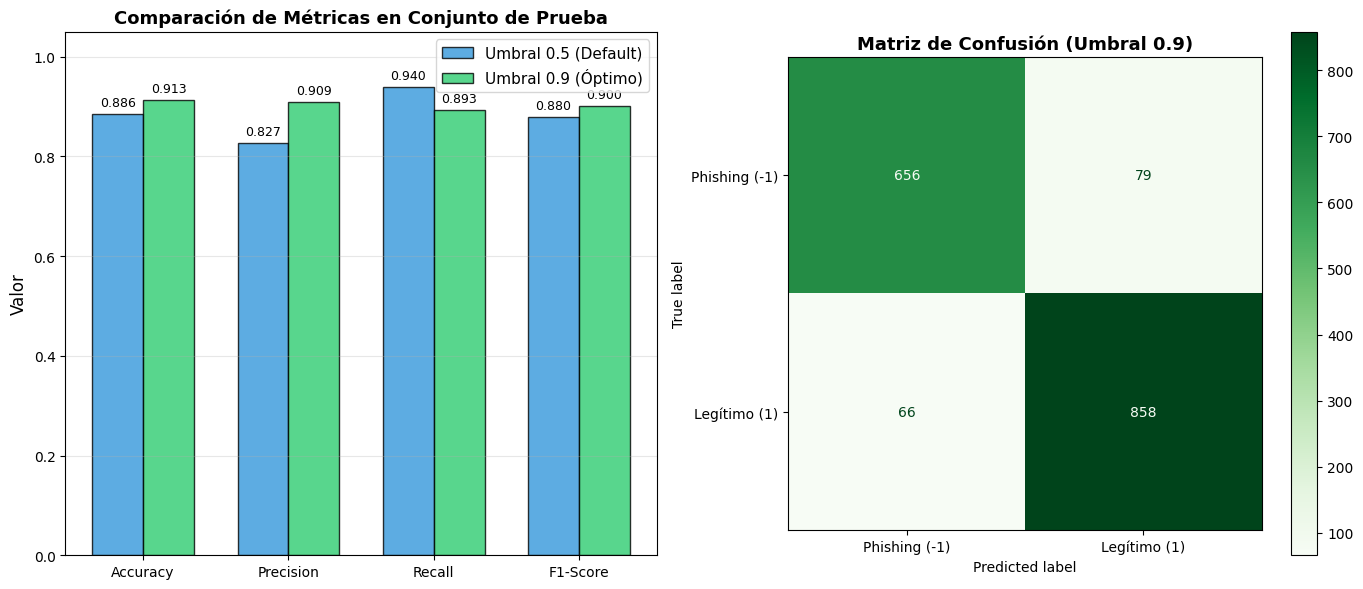


RESUMEN DEL AJUSTE DE UMBRAL

✅ Umbral óptimo encontrado: 0.9

📈 Impacto en el conjunto de prueba:
   • Recall ajustado de 94.01% a 89.25%
   • Precision mejorada de 82.66% a 90.86%
   • F1-Score cambió de 0.8797 a 0.9005

💡 Conclusión:
   El ajuste de umbral MEJORÓ el desempeño general del modelo


In [109]:
# ============================================
# Evaluación en Conjunto de Prueba con Umbral Óptimo
# ============================================

print("\n" + "=" * 60)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA CON UMBRAL ÓPTIMO")
print("=" * 60)

# Aplicar el mejor umbral al conjunto de prueba
umbral_optimo = (
    mejor_resultado['Umbral'] if 'mejor_resultado' in globals()
    else (threshold_opt if 'threshold_opt' in globals() else resultados_umbrales_df.loc[resultados_umbrales_df['F1'].idxmax(), 'Umbral'])
)

y_pred_test_umbral = np.where(proba_phishing_test >= umbral_optimo, -1, 1)

# Calcular métricas en prueba
acc_test_umbral = accuracy_score(y_test, y_pred_test_umbral)
prec_test_umbral = precision_score(y_test, y_pred_test_umbral, pos_label=-1, zero_division=0)
rec_test_umbral = recall_score(y_test, y_pred_test_umbral, pos_label=-1, zero_division=0)
f1_test_umbral = f1_score(y_test, y_pred_test_umbral, pos_label=-1, zero_division=0)

print(f"\n📊 Métricas en Prueba con Umbral Óptimo ({umbral_optimo}):")
print(f"  - Accuracy:  {acc_test_umbral:.4f} ({acc_test_umbral*100:.2f}%)")
print(f"  - Precision: {prec_test_umbral:.4f} ({prec_test_umbral*100:.2f}%)")
print(f"  - Recall:    {rec_test_umbral:.4f} ({rec_test_umbral*100:.2f}%)")
print(f"  - F1-Score:  {f1_test_umbral:.4f} ({f1_test_umbral*100:.2f}%)")

# Matriz de confusión
cm_test_umbral = confusion_matrix(y_test, y_pred_test_umbral)
print("\n📋 Matriz de Confusión (Prueba - Umbral Óptimo):")
print(cm_test_umbral)

tp_test = cm_test_umbral[0, 0]
fn_test = cm_test_umbral[0, 1]
fp_test = cm_test_umbral[1, 0]
tn_test = cm_test_umbral[1, 1]

print(f"\n  TP (Verdaderos Positivos):  {tp_test} - Phishing detectado ✅")
print(f"  FN (Falsos Negativos):      {fn_test} - Phishing NO detectado ⚠️")
print(f"  FP (Falsos Positivos):      {fp_test} - Falsas alarmas ⚠️")
print(f"  TN (Verdaderos Negativos):  {tn_test} - Legítimos correctos ✅")

# Comparación con el pipeline (umbral 0.5) en prueba
print("\n" + "=" * 60)
print("COMPARACIÓN FINAL: PIPELINE (0.5) VS UMBRAL ÓPTIMO EN PRUEBA")
print("=" * 60)

comparacion_final = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Pipeline (umbral 0.5)': [acc_test_pipeline, prec_test_pipeline, rec_test_pipeline, f1_test_pipeline],
    f'Umbral Óptimo ({umbral_optimo})': [acc_test_umbral, prec_test_umbral, rec_test_umbral, f1_test_umbral],
    'Mejora': [
        acc_test_umbral - acc_test_pipeline,
        prec_test_umbral - prec_test_pipeline,
        rec_test_umbral - rec_test_pipeline,
        f1_test_umbral - f1_test_pipeline
    ]
})

display(comparacion_final.round(4))

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de barras comparativo
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
base_vals = [acc_test_pipeline, prec_test_pipeline, rec_test_pipeline, f1_test_pipeline]
optimo_vals = [acc_test_umbral, prec_test_umbral, rec_test_umbral, f1_test_umbral]

x = np.arange(len(metricas))
width = 0.35

bars1 = axes[0].bar(x - width/2, base_vals, width, label='Umbral 0.5 (Default)', 
                    color='#3498db', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, optimo_vals, width, label=f'Umbral {umbral_optimo} (Óptimo)',
                    color='#2ecc71', alpha=0.8, edgecolor='black')

axes[0].set_ylabel('Valor', fontsize=12)
axes[0].set_title('Comparación de Métricas en Conjunto de Prueba', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metricas)
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.05])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Matriz de confusión con umbral óptimo
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_umbral,
                               display_labels=['Phishing (-1)', 'Legítimo (1)'])
disp.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'Matriz de Confusión (Umbral {umbral_optimo})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("RESUMEN DEL AJUSTE DE UMBRAL")
print("=" * 60)
print(f"\n✅ Umbral óptimo encontrado: {umbral_optimo}")
print(f"\n📈 Impacto en el conjunto de prueba:")
print(f"   • Recall ajustado de {rec_test_pipeline:.2%} a {rec_test_umbral:.2%}")
print(f"   • Precision mejorada de {prec_test_pipeline:.2%} a {prec_test_umbral:.2%}")
print(f"   • F1-Score cambió de {f1_test_pipeline:.4f} a {f1_test_umbral:.4f}")
print(f"\n💡 Conclusión:")
if f1_test_umbral > f1_test_pipeline:
    print(f"   El ajuste de umbral MEJORÓ el desempeño general del modelo")
else:
    print(f"   El umbral por defecto (0.5) funciona bien para este modelo")